In [27]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip


--2022-03-05 17:25:01--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 142.251.6.128, 142.251.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M   210MB/s    in 0.3s    

2022-03-05 17:25:01 (210 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]



In [28]:
import tensorflow as tf
import numpy as np 
import random 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os 
import zipfile 

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import RMSprop 
from keras.preprocessing import image 

from google.colab import files 



In [29]:
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [30]:
!pwd
!ls
!ls cats_and_dogs_filtered

/content
cats_and_dogs_filtered	    cats_and_dogs_filtered.zip.1
cats_and_dogs_filtered.zip  sample_data
train  validation  vectorize.py


In [31]:
base_dir = 'cats_and_dogs_filtered'

print('Contents of base directory:')
print(os.listdir(base_dir))

print('\nContents of train directory:')
print(os.listdir(f'{base_dir}/train'))

print('Contents of validation directory:')
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['validation', 'train', 'vectorize.py']

Contents of train directory:
['cats', 'dogs']
Contents of validation directory:
['cats', 'dogs']


In [32]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# training pictures cats / dogs 
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# validation pictures cats / dogs 
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print('Path to training pictrues of cats:   ',train_cats_dir)
print('Path to training pictrues of dogs:   ',train_dogs_dir)
print('Path to validation pictrues of cats: ',validation_cats_dir)
print('Path to validation pictrues of dogs: ',validation_dogs_dir)

Path to training pictrues of cats:    cats_and_dogs_filtered/train/cats
Path to training pictrues of dogs:    cats_and_dogs_filtered/train/dogs
Path to validation pictrues of cats:  cats_and_dogs_filtered/validation/cats
Path to validation pictrues of dogs:  cats_and_dogs_filtered/validation/dogs


In [33]:
# names of the files in the cats and dogs train directories 
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

print(train_cats_fnames[:10])
print(train_dogs_fnames[:10])

['cat.11.jpg', 'cat.496.jpg', 'cat.529.jpg', 'cat.169.jpg', 'cat.426.jpg', 'cat.76.jpg', 'cat.67.jpg', 'cat.279.jpg', 'cat.965.jpg', 'cat.284.jpg']
['dog.612.jpg', 'dog.154.jpg', 'dog.776.jpg', 'dog.826.jpg', 'dog.730.jpg', 'dog.298.jpg', 'dog.505.jpg', 'dog.949.jpg', 'dog.739.jpg', 'dog.860.jpg']


In [34]:
# number of images in both training and validation 
print(f'Total number of training cat images: {len(os.listdir(train_cats_dir))}')
print(f'Total number of training dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Total number of validation cat images: {len(os.listdir(validation_cats_dir))}')
print(f'Total number of validation dog images: {len(os.listdir(validation_dogs_dir))}')

Total number of training cat images: 1000
Total number of training dog images: 1000
Total number of validation cat images: 500
Total number of validation dog images: 500


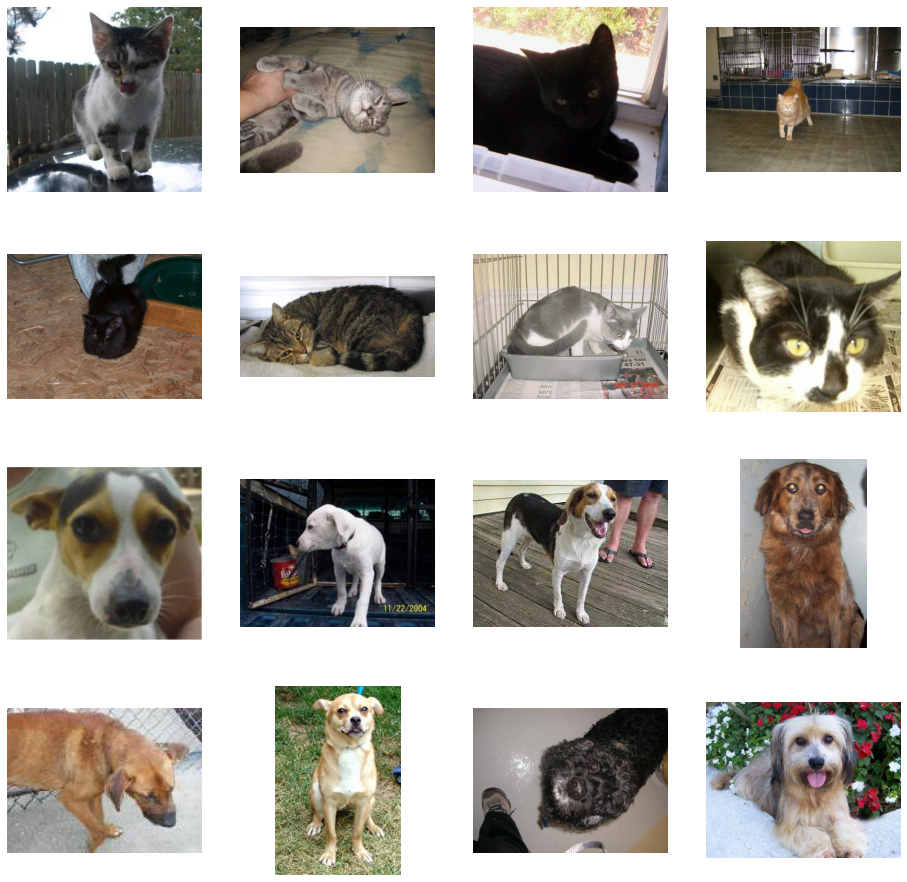

In [35]:
%matplotlib inline
# parameters for graph - 4x4 output
nrows = 4 
ncols = 4
pic_index = 0 # index for iterating over images 
fig = plt.gcf() # get the current figure 

fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cats_fnames[pic_index-8:pic_index]]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dogs_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix + next_dog_pix):
    # subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [36]:
# in course materials we built following model with 72% accuracy, 
# I decided to use augumentation techniques to boost results 

"""
# model from course material
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])
"""

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])


In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 64)      

In [38]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Stop training when a monitored metric has stopped improving.
callback = EarlyStopping(monitor='val_loss', 
                         min_delta=1e-3, 
                         patience=5, 
                         mode='auto')

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# rescaling images by 1./255.
# I added also augumentation. On pictures we can se dogs and cats 
# in many different poses so it makes sens to rotate the same photo even 180

train_datagen = ImageDataGenerator(rescale = 1.0 / 255.,
                                   rotation_range=45,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',)

test_datagen = ImageDataGenerator(rescale = 1.0 / 255.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150)) 
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

history = model.fit(
            train_generator,
            steps_per_epoch=100,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=50,
            batch_size=16,
            callbacks=[callback],
            verbose=2
            )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 - 66s - loss: 0.6936 - accuracy: 0.5275 - val_loss: 0.7054 - val_accuracy: 0.5000 - 66s/epoch - 661ms/step
Epoch 2/100
100/100 - 65s - loss: 0.6876 - accuracy: 0.5335 - val_loss: 0.6832 - val_accuracy: 0.5000 - 65s/epoch - 649ms/step
Epoch 3/100
100/100 - 65s - loss: 0.6718 - accuracy: 0.5910 - val_loss: 0.6228 - val_accuracy: 0.6720 - 65s/epoch - 647ms/step
Epoch 4/100
100/100 - 65s - loss: 0.6659 - accuracy: 0.5760 - val_loss: 0.6189 - val_accuracy: 0.6620 - 65s/epoch - 646ms/step
Epoch 5/100
100/100 - 65s - loss: 0.6537 - accuracy: 0.6220 - val_loss: 0.6552 - val_accuracy: 0.6090 - 65s/epoch - 649ms/step
Epoch 6/100
100/100 - 64s - loss: 0.6465 - accuracy: 0.6415 - val_loss: 0.6609 - val_accuracy: 0.5620 - 64s/epoch - 644ms/step
Epoch 7/100
100/100 - 64s - loss: 0.6327 - accuracy: 0.6475 - val_loss: 0.5935 - val_accuracy: 0.6770 - 64s/epoch - 643ms/step
Epoch 8/100
100/100 - 64s -

Text(0.5, 1.0, 'Training and validation loss')

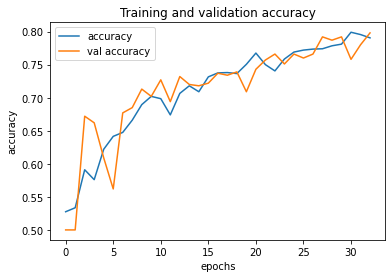

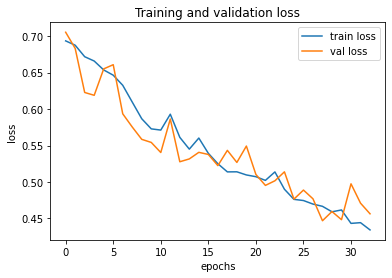

In [39]:
# Evaluation of Accuracy and Loss for the model 
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, label='accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(epochs, val_acc, label='val accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='train loss')
plt.plot  ( epochs, val_loss, label='val loss' )
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title ('Training and validation loss'   )


In [41]:
!pip install celluloid

In [42]:

from celluloid import Camera
# Animation of the results 
fig, ax = plt.subplots(figsize=(16,10))
camera = Camera(fig)
ax.set_ylabel('value: 0 - 1', fontsize=15)
ax.set_xlabel('epoch', fontsize=15)
# ax.legend(['training loss', 'validation loss'])

for i in epochs:
    ax.plot(epochs[i], acc[i], marker='>', markersize=12, markeredgecolor='b', markerfacecolor='b')
    ax.plot(epochs[i], val_acc[i],  marker='>', markersize=12, markeredgecolor='g', markerfacecolor='g')
    ax.plot(epochs[i], loss[i], marker='>', markersize=12, markeredgecolor='r', markerfacecolor='r')
    ax.plot(epochs[i], val_loss[i], marker='>', markersize=12, markeredgecolor='y', markerfacecolor='y')
    
    ax.plot(epochs[:i+1], val_loss[:i+1] , color='y', lw=2, linestyle='--')
    ax.plot(epochs[:i+1], val_acc[:i+1], color='g', lw=2, linestyle='--')
    ax.plot(epochs[:i+1], acc[:i+1],  color='b', lw=2, linestyle='--')
  
    ax.plot(epochs[:i+1], loss[:i+1] , color='r', lw=2, linestyle='--')
    

    camera.snap()
    ax.legend(['training accuracy', 'validation accuracy', 'training loss', 'validation loss'])
plt.close()

In [44]:
from IPython.display import HTML
anim = camera.animate(interval = 500, repeat = True, repeat_delay = 500)
HTML(anim.to_html5_video())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


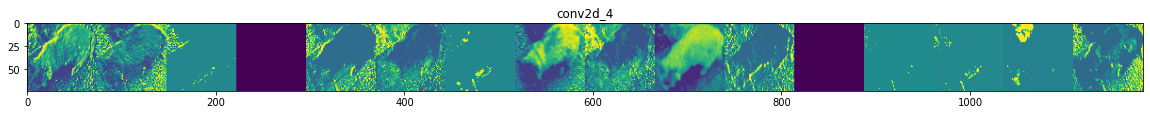

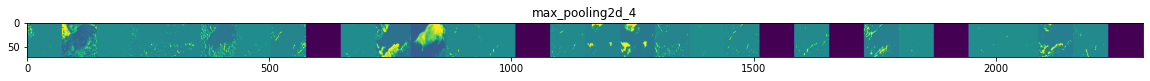

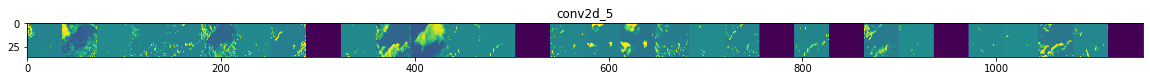

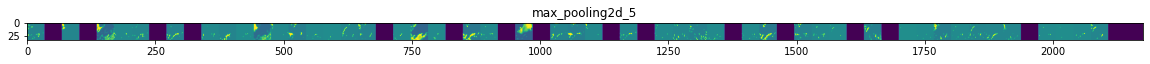

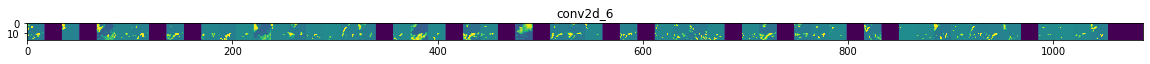

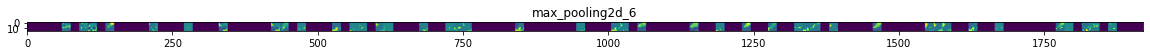

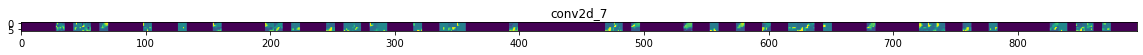

In [46]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cats_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dogs_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 